In [2]:
from pytket.circuit import Circuit, fresh_symbol
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.quantinuum import QuantinuumBackend
import matplotlib.pyplot as pl

import os
print(os.getcwd())

from pytket.extensions.qiskit import qiskit_to_tk, AerBackend
from pytket.backends.backendresult import BackendResult

import qiskit as qk

import pickle
import pandas as pd
import numpy as np

/Users/utkarshagrawal/Documents/Postdoc/U_1_exp/Quantinum/Weak measurements


In [76]:
def load_file(L,depth,p,Q):
    file_loc = '../../Weak measurements/data/circ_data/special_scrambling/basis_gate_set=1/L='+str(L)+'_depth='+str(depth)+'_Q='+str(Q)+'_p='+str(p)+'_seed=1.imdat'
    with open (file_loc,'rb') as f:
        circ_q = pickle.load(f)
    return circ_q


In [77]:
# This function removes any save_statevector instruction from the qiskit circuit as it is not recognized by quantinuum backend.
def remove_save_statevector(circ_q):

    position = 0
    count = 0
    save_positions = []
    for inst in circ_q.data:
        if inst.operation.name == 'save_statevector':
            count+=1
            save_positions.append(position)
        position+=1

    new_circ = circ_q.copy()
    for pos in reversed(save_positions):
        new_circ.data.pop(pos)

    # print("Before remvoing: # of save instructions = ",count,'\n save positions = ',save_positions,'\n save positions = ',position)

    position = 0
    count = 0
    save_positions = []
    for inst in new_circ.data:
        if inst.operation.name == 'save_statevector':
            count+=1
            save_positions.append(position)
        position+=1
    # print("After remvoing: # of save instructions = ",count,'\n save positions = ',save_positions,'\n save positions = ',position)
    return new_circ


In [63]:
machine = 'H1-1E'
backend = QuantinuumBackend(machine)
# backend.login()

print(machine, "status:", backend.device_state(device_name=machine))

H1-1E status: online


In [78]:
def compiled_tket_circuit(L,depth,p,Q):
    circ_q = load_file(L,depth,p,Q)
    new_circ = remove_save_statevector(circ_q['circuit'])
    circ_p = qiskit_to_tk(new_circ)
    compiled_circ = backend.get_compiled_circuit(circ_p)
    # render_circuit_jupyter(circ_p)

    return compiled_circ

In [79]:
def cost(L,depth,p,Q,n_shots):
    compiled_circ = compiled_tket_circuit(L,depth,p,Q)
    HQC = backend.cost(compiled_circ, n_shots=n_shots, syntax_checker='H1-1SC')
    return HQC

In [81]:
compiled_circ = compiled_tket_circuit(10,10,0.412,5)

In [82]:
print(len(compiled_circ.get_commands()))

955


In [74]:
backend.cost(compiled_circ,200,syntax_checker='H1-1SC')

161.12

In [43]:
handle = backend.process_circuit(compiled_circ,n_shots=10)

In [57]:
200*(7.7940000000000005 - 5)/10 + 5

60.88000000000001

In [50]:
backend.circuit_status(handle)

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "circuit-19309", "submit-date": "2023-01-10T19:37:25.550958", "result-date": "2023-01-10T19:38:25.376555", "queue-position": null, "cost": "7.7940000000000005", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)

In [51]:
results = backend.get_result(handle)
print(results.get_shots())

[[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1]
 [0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1]
 [1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1]
 [0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0]
 [0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1]]


In [154]:
data_dict = {'L':[],'Q':[],'p':[],'cost':[],'shots':[]}

In [155]:
def get_L(filename):
    temp = filename[2:4]
    if '_' in temp:
        temp = temp[:-1]
    return int(temp)
    
def get_Q(filename):
    index = filename.index('Q')
    temp = filename[index+2:index+4]
    if '_' in temp:
        temp = temp[:-1]
    return int(temp)

def get_p(filename):
    index = filename.index('p=')
    temp = filename[index+2:index+7]
    while '_' in temp:
        temp = temp[:-1]
    return float(temp)


## Running emulator

In [238]:
machine = 'H1-1E'
backend = QuantinuumBackend(machine)
# backend.login()

print(machine, "status:", backend.device_state(device_name=machine))

H1-1E status: online


In [259]:
compiled_circ = compiled_tket_circuit(6,6,0.942,3)
handle = backend.process_circuit(compiled_circ, 
                                 n_shots=200)
print(handle)

('a8986ed76d0f438cb0ebb6c903a4ecf2', 'null')


In [271]:
file_dir = file_loc = "../../Weak measurements/data/circ_data/special_scrambling/basis_gate_set=1/"
compiled_circuits = {}
for file in os.listdir(file_dir):
    L = get_L(file)
    p = get_p(file)
    Q = get_Q(file)
    depth = L
    file_loc = file_dir + file
    temp = compiled_tket_circuit(L=L,depth=L,p=p,Q=Q)
    compiled_circuits[(L,depth,p,Q)] = temp


In [273]:
print(len(compiled_circuits))

180


In [314]:
[param for param in compiled_circuits]

[(14, 14, 0.253, 7),
 (10, 10, 0.306, 4),
 (16, 16, 0.73, 8),
 (8, 8, 0.571, 4),
 (14, 14, 0.412, 7),
 (8, 8, 0.783, 4),
 (10, 10, 0.624, 5),
 (10, 10, 0.465, 4),
 (12, 12, 0.942, 5),
 (8, 8, 0.942, 3),
 (10, 10, 0.2, 4),
 (12, 12, 0.2, 5),
 (12, 12, 0.624, 6),
 (10, 10, 0.571, 4),
 (8, 8, 0.306, 4),
 (14, 14, 0.889, 6),
 (14, 14, 0.359, 6),
 (14, 14, 0.677, 6),
 (10, 10, 0.783, 4),
 (14, 14, 0.836, 6),
 (8, 8, 0.465, 4),
 (14, 14, 0.518, 6),
 (10, 10, 0.677, 5),
 (10, 10, 0.518, 5),
 (8, 8, 0.412, 4),
 (10, 10, 0.836, 5),
 (14, 14, 0.783, 7),
 (14, 14, 0.571, 7),
 (12, 12, 0.2, 6),
 (10, 10, 0.359, 5),
 (10, 10, 0.889, 5),
 (16, 16, 0.2, 7),
 (8, 8, 0.253, 4),
 (14, 14, 0.2, 6),
 (14, 14, 0.465, 7),
 (14, 14, 0.624, 6),
 (10, 10, 0.412, 4),
 (12, 12, 0.359, 6),
 (12, 12, 0.889, 6),
 (12, 12, 0.677, 6),
 (10, 10, 0.253, 4),
 (14, 14, 0.306, 7),
 (6, 6, 0.942, 3),
 (12, 12, 0.518, 6),
 (12, 12, 0.836, 6),
 (14, 14, 0.889, 7),
 (14, 14, 0.359, 7),
 (8, 8, 0.73, 4),
 (10, 10, 0.571, 5),
 

In [85]:
with open('test.txt','wb') as f:
    f.write([str(i) for i in [1,2,3,4]])

TypeError: a bytes-like object is required, not 'list'

In [315]:
n_shots = 50
count = 0
handle_dict = {}
p_list = [0.624,0.677,0.73,0.783,0.836]
for param,circ in compiled_circuits.items():
    L,depth,p,Q = param
    if L!=6:
        continue
    if p not in p_list:
        continue
    if count == 0:
        first_batch = backend.start_batch(max_batch_cost=500,circuit=circ, n_shots=n_shots)
        handle_dict[param] = first_batch
    else:
        new_batch = backend.add_to_batch(first_batch, circ, n_shots=n_shots)
        handle_dict[param] = new_batch
    count += 1


FileNotFoundError: [Errno 2] No such file or directory: 'data/emulator_batch_L=6_shots=50'

In [319]:
count

10

In [317]:
with open("data/emulator_batch_L=6_shots=50",'wb') as f:
    pickle.dump(handle_dict,f)

In [322]:
[backend.circuit_status(handle) for handle in handle_dict.values()]

[CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "circuit-20509", "submit-date": "2023-01-05T18:58:09.037442", "result-date": "2023-01-05T18:59:25.379123", "queue-position": null, "cost": "18.97", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None),
 CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "circuit-24109", "submit-date": "2023-01-05T18:58:09.325107", "result-date": "2023-01-05T18:59:45.190671", "queue-position": null, "cost": "18.95", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None),
 CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "circuit-26509", "submit-da

In [309]:
# result_dict = {}
for param,handle in handle_dict.items():
    # if param != (14,14,0.253,6):
        # continue
    # result_dict[param] = backend.get_result(handle=handle)
    status = (backend.circuit_status(handle))
    print(param,status.status,status.message)
    # if status.status == com_status:
        # print(status.status)


(14, 14, 0.253, 7) StatusEnum.COMPLETED {"name": "circuit-112749", "submit-date": "2023-01-05T03:46:07.871289", "result-date": "2023-01-05T03:53:10.305794", "queue-position": null, "cost": "395.3", "error": null}
(10, 10, 0.306, 4) StatusEnum.ERROR {"name": "circuit-112749", "submit-date": "2023-01-05T03:47:05.440855", "result-date": null, "queue-position": null, "cost": "0", "error": {"code": 1002, "text": "Job cost exceeds allowed cost"}}
(16, 16, 0.73, 8) StatusEnum.ERROR {"name": "circuit-512226", "submit-date": "2023-01-05T03:47:05.915826", "result-date": null, "queue-position": null, "cost": "0", "error": {"code": 1002, "text": "Job cost exceeds allowed cost"}}
(8, 8, 0.571, 4) StatusEnum.ERROR {"name": "circuit-64641", "submit-date": "2023-01-05T03:47:06.185621", "result-date": null, "queue-position": null, "cost": "0", "error": {"code": 1002, "text": "Job cost exceeds allowed cost"}}
(14, 14, 0.412, 7) StatusEnum.ERROR {"name": "circuit-230712", "submit-date": "2023-01-05T03:47

In [269]:
with open('test_handle.dat','rb') as f:
    han = pickle.load(f)
result = backend.get_result(han)


## Calculating cost

In [156]:
file_dir = file_loc = "../../Weak measurements/data/circ_data/special_scrambling/basis_gate_set=1/"
n_shots = 200
count = 0
for file in os.listdir(file_dir):
    L = get_L(file)
    p = get_p(file)
    Q = get_Q(file)
    depth = L
    if p!=0.412 or Q!=int(L/2):
        continue
    file_loc = file_dir + file
    costHQC = cost(L=L,p=p,Q=Q,depth=depth,n_shots=n_shots)
    data_dict['L'].append(L)
    data_dict['Q'].append(Q)
    data_dict['p'].append(p)
    data_dict['cost'].append(costHQC)
    data_dict['shots'].append(n_shots)
    count+=1
    print(count,L,Q,p,costHQC)
    with open('cost_data','wb') as f:
        pickle.dump(data_dict,f)
    

1 14 7 0.412 315.56
2 8 4 0.412 None
3 10 5 0.412 161.12
4 12 6 0.412 231.2
5 6 3 0.412 60.72
6 16 8 0.412 410.96


In [176]:
data_dict

{'L': [14, 8, 10, 12, 6, 16],
 'Q': [7, 4, 5, 6, 3, 8],
 'p': [0.412, 0.412, 0.412, 0.412, 0.412, 0.412],
 'cost': [315.56, 102.48, 161.12, 231.2, 60.72, 410.96],
 'shots': [200, 200, 200, 200, 200, 200]}

In [237]:
df = pd.read_csv('cost_data.csv')
df = df.drop(df.columns[[0]],axis=1)
new_data = pd.DataFrame(data_dict)
new_data = new_data.sort_values(['L'],ignore_index=True)
temp = pd.concat([df,new_data],ignore_index=True)
n_L = len(new_data)
index = len(df)
total_c = round(np.sum(np.array(temp['cost'][index:index+n_L],dtype=float)),2)
new_row = pd.DataFrame({'cost':'Total cost='+str(total_c)},index=[6])
temp = pd.concat([temp[:index+n_L],new_row,temp[index+n_L:]],ignore_index=True)
print(temp.drop_duplicates())


       L    Q      p                cost  shots
0    6.0  3.0  0.412               60.72  200.0
1    8.0  4.0  0.412              102.48  200.0
2   10.0  5.0  0.412              161.12  200.0
3   12.0  6.0  0.412               231.2  200.0
4   14.0  7.0  0.412              315.56  200.0
5   16.0  8.0  0.412              410.96  200.0
6    NaN  NaN    NaN  Total cost=1282.04    NaN
7    6.0  3.0  0.412               144.3  500.0
8    8.0  4.0  0.412               248.7  500.0
9   10.0  5.0  0.412               395.3  500.0
10  12.0  6.0  0.412               570.5  500.0
11  14.0  7.0  0.412               781.4  500.0
12   NaN  NaN    NaN   Total cost=2140.2    NaN
13   6.0  3.0  0.412               60.72  200.0
14   8.0  4.0  0.412              102.48  200.0
15  10.0  5.0  0.412              161.12  200.0
16  12.0  6.0  0.412               231.2  200.0
17  14.0  7.0  0.412              315.56  200.0
18  16.0  8.0  0.412              410.96  200.0


In [109]:
df['cost']

0    144.3
1    248.7
2    395.3
3    570.5
4    781.4
Name: cost, dtype: float64

In [167]:
df = df.rename(columns={'cost in HQC':'cost'})

In [168]:
df

,L,Q,p,cost,shots
0,6.0,3.0,0.412,144.3,500.0
1,8.0,4.0,0.412,248.7,500.0
2,10.0,5.0,0.412,395.3,500.0
3,12.0,6.0,0.412,570.5,500.0
4,14.0,7.0,0.412,781.4,500.0
5,NaN,NaN,NaN,Total cost=2140.2,NaN


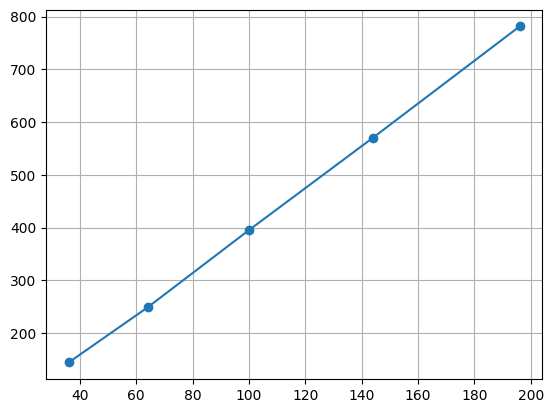

In [153]:
pl.plot(np.array(df['L'][:-1])**2,(np.array(df['cost in HQC'][:-1],dtype=float)),'-o')

pl.grid(which='both')

In [151]:

np.array(df['cost in HQC'][:-1])

array([144.3, 248.7, 395.3, 570.5, 781.4], dtype=object)

In [206]:
temp.to_csv('cost_data.csv')

In [135]:
((((2140.2-5*5)*(100/500)+5*5)*2)*6/500)/3

3.58432

In [97]:
df = pd.DataFrame()

In [98]:
df['p'] = [0.1,0.2,0.3]
L_list = [1]
if len(L_list)<len(df)

df['shots'] = [200]*3

ValueError: Length of values (1) does not match length of index (3)

In [100]:
len(df)

3